<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/practical-machine-learning-for-computer-vision/02-ml-models-for-vision/03_neural_network_for_machine_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Neural Network for machine perception

In this notebook, you will learn how to represent images and train basic machine learning models to classify images. You will discover that **the performance of linear and fully connected neural networks is poor on images.** However, along the way, you will learn how to use the Keras API to implement ML primitives and train ML models.

## Setup

In [1]:
!pip install --quiet keras-tuner

     |████████████████████████████████| 97 kB 3.7 MB/s 


In [2]:
import tensorflow as tf

print(tf.version.VERSION)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.6.0
Found GPU at: /device:GPU:0


In [3]:
import kerastuner as kt

import matplotlib.pylab as plt
import matplotlib
import numpy as np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [4]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

In [5]:
!gsutil cat gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv | head -20

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg,roses
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/4558536575_d43a611bd4_n.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/7568630428_8cf0fc16ff_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/7064813645_f7f48fb527.jpg,tulips
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/4933229095

## Dataset for Machine Perception

Assume that we have collected and labeled a dataset of nearly four thousand photographs of flowers. There are five types of flowers in the `5-flowers` dataset and each image in the dataset has already been labeled with the type of flower it depicts.

<img src='https://github.com/rahiakela/computer-vision-research-and-practice/blob/main/practical-machine-learning-for-computer-vision/02-ml-models-for-vision/images/1.png?raw=1' width='800'/>

We are asking the machine learning model to learn to perceive what’s in the image, so you might see this type of task called machine perception. Specifically, the type of perception is analogous to human sight,
so the problem is termed computer vision, and in this case we will solve it through image classification.

### Reading Image Data

The 5-flowers dataset was created by Google and placed in the public domain with a Creative Commons license. It is published as a TensorFlow dataset and available in a public Google Cloud Storage bucket `(gs://cloud-ml-data/)` in the form of JPEG files. This makes the dataset both realistic (it consists of JPEG photographs of the sort collected by off-the-shelf cameras) and readily accessible.

There are four steps to reading an image in a standard format like JPEG or PNG and getting it ready to train machine learning models with it.

In [6]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # 1.Read the file
  img = tf.io.read_file(filename)
  # 2.Convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # 3.Use `convert_image_dtype` to convert to floats in the [0,1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 4.Resize the image to the desired size
  return tf.image.resize(img, reshape_dims)

In [7]:
CLASS_NAMES = [
               item.numpy().decode("utf-8") 
               for item in tf.strings.regex_replace(tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                                                    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")
              ]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:\n", CLASS_NAMES)

These are the available classes:
 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


##Non-Linear Model using Keras

In [8]:
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [9]:
BATCH_SIZE = 32

train_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").map(decode_csv)).batch(BATCH_SIZE)
eval_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").map(decode_csv)).batch(BATCH_SIZE)

In the linear model, we wrote the Keras model as:

In [ ]:
model = tf.keras.Sequential([
     tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     tf.keras.layers.Dense(len(CLASS_NAMES))                        
])

The output is the softmax of the weighted average of the flattened input pixel values:

$$Y = softmax(B + \sum_{pixels} W_iX_i)$$

B is the bias tensor, W the weights tensor, X the input tensor, and Y the output tensor.

This is usually written in matrix form as (using § to represent the softmax):

$$Y =  §(B +  WX)$$

In [ ]:
# compile the model
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


Linear models are great, but they are limited in what they can model. How do we
obtain more complex models?

###Neural Networks

One way to get a more complex model is to interpose one or more Dense layers in
between the input and output layers. This results in a machine learning model called a neural network.

Suppose that we interpose one more Dense layer using:

In [ ]:
model = tf.keras.Sequential([
     tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     tf.keras.layers.Dense(128),
     tf.keras.layers.Dense(len(CLASS_NAMES))                        
])

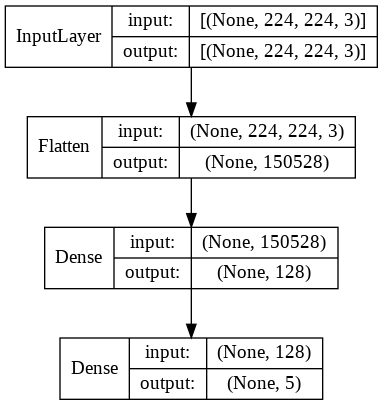

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

The model now has three layers. A layer with trainable weights, such as the one we added that is neither the input nor the output layer, is called a
hidden layer.

Mathematically, the output is now:

$$Y =  §(B_2 + W_2(B_1 +  W_1X))$$

Simply wrapping multiple layers like this is pointless, since we might as well have multiplied the second layer’s weight $(W_2)$ into the equation—the model remains a linear model. However, if we add a nonlinear activation function $A(x)$ to transform the output of the hidden layer:

$$Y =  §(B_2 + W_2A(B_1 +  W_1X))$$

then the output becomes capable of representing more complex relationships than a simple linear function.

In [ ]:
model = tf.keras.Sequential([
     tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')                        
])

In [ ]:
# compile the model
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               19267712  
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
104/104 [==============================] - 191s 2s/step - loss: 1.7373 - accuracy: 0.2473 - val_loss: 1.6094 - val_accuracy: 0.2351
Epoch 2/10
104/104 [==============================] - 138s 1s/step - loss: 1.6094 - accuracy: 0.2458 - val_loss: 1.6094 - val_accuracy: 0.2351
Epoch 3/10
104/104 [==============================] - 132s 1s/step - loss: 1.6094 - accuracy: 0.2458 - val_loss: 1.6094 - val_accuracy: 0.2351
Epoch 4/10
104/104 [==============================] - 124s 1s/step - loss: 1.6094 - accuracy: 0.2458 - val_loss: 1.6094 - val_accuracy: 0.2351
Epoch 5/10
104/104 [==============================] - 119s 1s/step - loss: 1.6094 - accuracy: 0.2458 - val_loss: 1.6094 - val_accuracy: 0.2351
Epoch 6/10
104/104 [==============================] - 116s 1s/step - loss: 1.6094 - accuracy: 0.2458 - val_loss: 1.6094 - val_accuracy: 0.2351
Epoch 7/10
104/104 [==============================] - 109s 1s/step - loss: 1.6094 - accuracy: 0.2458 - val_loss: 1.6094 - val_accuracy: 0.2351

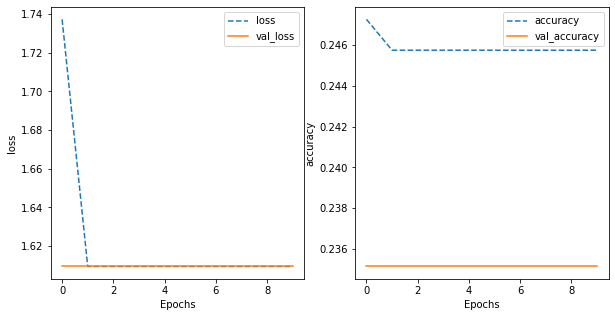

In [ ]:
training_plot(['loss', 'accuracy'], history)

The result reveals that the best validation accuracy that we
have obtained (0.45) is similar to what we obtained with a linear model. 

The curves are also not smooth.

There are still some improvements that we can try, though. For example, we can
change the learning rate and the loss function, and make better use of the validation dataset.

####Learning rate

A gradient descent optimizer works by looking in all directions at each point and picking the direction where the error function is decreasing the most rapidly. Then it makes a step in that direction and tries again.

Then, the optimizer updates the weight value by making a step in that direction,
as indicated by the dashed curved line. The size of this step for every weight
value is proportional to a model hyperparameter called the **learning rate**.

<img src='https://github.com/rahiakela/computer-vision-research-and-practice/blob/main/practical-machine-learning-for-computer-vision/02-ml-models-for-vision/images/4.png?raw=1' width='800'/>

As you can see, if the learning rate is too high, the optimizer might skip over the minima
completely. After this step (denoted by the circle marked 2 in the figure), the
optimizer again looks in two directions and then continues to the third point, because
the loss curve is dropping faster in that direction. After this step, the gradient is evaluated
again. Now the direction points backward, and the optimizer manages to find
the local minimum in between the second and third points. The global minimum
which was between the first and second steps has, however, been missed.

In order to not skip over minima, we should use a small value for the learning rate.
But if the learning rate is too small, the model will get stuck in a local minimum. Also,
the smaller the value of the learning rate, the slower the model will converge. Thus,
there’s a trade-off between not missing minima and getting the model to converge
quickly.



####Regularization

Given that we have a relatively small dataset for the complexity of the model that we
are using, it is possible that the model will start to use individual trainable weights to
“memorize” the classification answers for individual images in the training dataset—
this is the overfitting.

When this happens, the weight values start to become highly tuned to very specific
pixel values and attain very high values. Therefore, we can reduce the incidence of
overfitting by changing the loss to apply a penalty on the weight values themselves.
This sort of penalty applied to the loss function is called regularization.

The first type of penalty is called an L1 regularization term, and the second is called
an L2 regularization term. Either penalty will cause the optimizer to prefer smaller
weight values. L1 regularization drives many of the weight values to zero but is more
tolerant of individual large weight values than L2 regularization, which tends to drive
all the weights to small but nonzero values.

In [ ]:
def train_and_evaluate(batch_size=32, lrate=0.001, l1=0, l2=0, num_hidden=128):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").map(decode_csv)).batch(BATCH_SIZE)
  eval_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").map(decode_csv)).batch(32)  # this doesn't matter

  # NN with one hidden layers
  model = tf.keras.Sequential([
     tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
     tf.keras.layers.Dense(num_hidden, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
     tf.keras.layers.Dense(len(CLASS_NAMES), kernel_regularizer=regularizer, activation='softmax')                        
  ])

  # compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
  # fit the model
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

  # plot the loss and accuracy
  training_plot(['loss', 'accuracy'], history)

  return model

Epoch 1/10
104/104 [==============================] - 107s 1s/step - loss: 2.0685 - accuracy: 0.3303 - val_loss: 1.3488 - val_accuracy: 0.4027
Epoch 2/10
104/104 [==============================] - 103s 988ms/step - loss: 1.4016 - accuracy: 0.4006 - val_loss: 1.3889 - val_accuracy: 0.3946
Epoch 3/10
104/104 [==============================] - 102s 984ms/step - loss: 1.3532 - accuracy: 0.4327 - val_loss: 1.3344 - val_accuracy: 0.4270
Epoch 4/10
104/104 [==============================] - 121s 1s/step - loss: 1.3034 - accuracy: 0.4600 - val_loss: 1.3020 - val_accuracy: 0.4649
Epoch 5/10
104/104 [==============================] - 119s 1s/step - loss: 1.2527 - accuracy: 0.4800 - val_loss: 1.3030 - val_accuracy: 0.4514
Epoch 6/10
104/104 [==============================] - 102s 981ms/step - loss: 1.2156 - accuracy: 0.4958 - val_loss: 1.3132 - val_accuracy: 0.4703
Epoch 7/10
104/104 [==============================] - 99s 956ms/step - loss: 1.1832 - accuracy: 0.5145 - val_loss: 1.3243 - val_accur

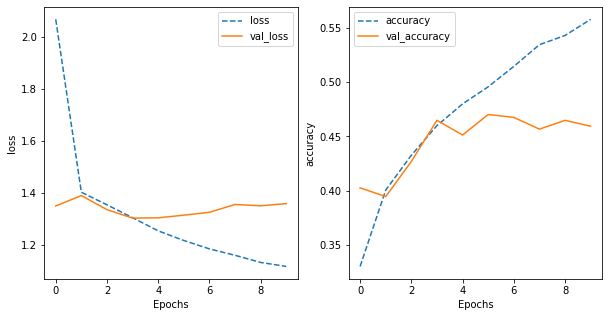

In [ ]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

Epoch 1/10
104/104 [==============================] - 97s 930ms/step - loss: 2.6975 - accuracy: 0.3664 - val_loss: 1.9002 - val_accuracy: 0.3486
Epoch 2/10
104/104 [==============================] - 108s 1s/step - loss: 1.8174 - accuracy: 0.4200 - val_loss: 2.1544 - val_accuracy: 0.3838
Epoch 3/10
104/104 [==============================] - 109s 1s/step - loss: 1.6171 - accuracy: 0.4612 - val_loss: 1.9778 - val_accuracy: 0.4405
Epoch 4/10
104/104 [==============================] - 99s 953ms/step - loss: 1.4019 - accuracy: 0.4894 - val_loss: 1.8944 - val_accuracy: 0.4378
Epoch 5/10
104/104 [==============================] - 112s 1s/step - loss: 1.4035 - accuracy: 0.5045 - val_loss: 1.3672 - val_accuracy: 0.4595
Epoch 6/10
104/104 [==============================] - 106s 1s/step - loss: 1.1683 - accuracy: 0.5585 - val_loss: 1.4616 - val_accuracy: 0.4811
Epoch 7/10
104/104 [==============================] - 105s 1s/step - loss: 1.0588 - accuracy: 0.5948 - val_loss: 1.5112 - val_accuracy: 0.

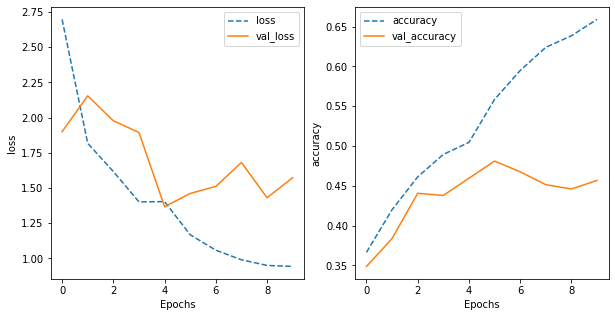

In [ ]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

Epoch 1/10
104/104 [==============================] - 123s 1s/step - loss: 2.6222 - accuracy: 0.3515 - val_loss: 1.5573 - val_accuracy: 0.4351
Epoch 2/10
104/104 [==============================] - 109s 1s/step - loss: 1.6668 - accuracy: 0.4245 - val_loss: 1.7550 - val_accuracy: 0.4378
Epoch 3/10
104/104 [==============================] - 101s 973ms/step - loss: 1.5271 - accuracy: 0.4691 - val_loss: 1.7458 - val_accuracy: 0.4270
Epoch 4/10
104/104 [==============================] - 125s 1s/step - loss: 1.4969 - accuracy: 0.4858 - val_loss: 1.5594 - val_accuracy: 0.4541
Epoch 5/10
104/104 [==============================] - 109s 1s/step - loss: 1.3937 - accuracy: 0.5239 - val_loss: 1.5952 - val_accuracy: 0.4486
Epoch 6/10
104/104 [==============================] - 100s 957ms/step - loss: 1.3151 - accuracy: 0.5500 - val_loss: 1.6644 - val_accuracy: 0.4378
Epoch 7/10
104/104 [==============================] - 98s 941ms/step - loss: 1.2690 - accuracy: 0.5700 - val_loss: 1.7466 - val_accuracy

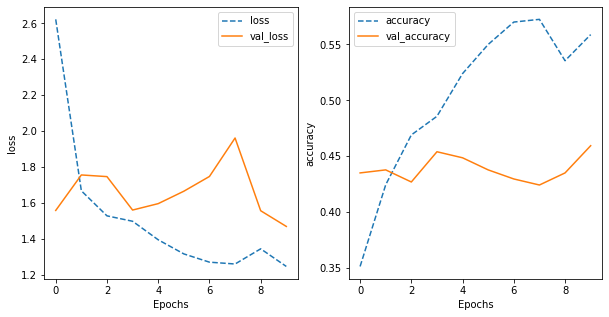

In [ ]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0.001, num_hidden=128)

###Hyperparameter tuning

We chose a number of parameters for our model: the number of hidden nodes, the
learning rate, the L2 regularization, and so on. How do we know that these are optimal? We don’t. We need to tune these hyperparameters.

One way to do this is to use the Keras Tuner. To use the Keras Tuner, we implement the model-building function to use hyperparameters.

In [10]:
def build_model(hp):
  lrate = hp.Float("lrate", 1e-4, 1e-1, sampling="log")
  l1 = 0
  l2 = hp.Choice("l2", values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4])
  num_hidden = hp.Int("num_hidden", 32, 256, 32)

  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  # NN with one hidden layers
  model = tf.keras.Sequential([
     tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
     tf.keras.layers.Dense(num_hidden, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
     tf.keras.layers.Dense(len(CLASS_NAMES), kernel_regularizer=regularizer, activation='softmax')                        
  ])

  # compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
  
  return model

In [11]:
train_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").map(decode_csv)).batch(BATCH_SIZE)
eval_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").map(decode_csv)).batch(32)  # this doesn't matter

We pass the build_model() function into a Keras Tuner optimization algorithm. Several algorithms are supported, but Bayesian optimization is an old standby that works well for computer vision problems:

In [12]:
tuner = kt.BayesianOptimization(build_model, objective=kt.Objective("val_accuracy", "max"), max_trials=10, num_initial_points=2, overwrite=False)

Having created the tuner, we can then run the search:

In [13]:
tuner.search(train_dataset, validation_data=eval_dataset, epochs=5, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 10 Complete [00h 12m 18s]
val_accuracy: 0.29729729890823364

Best val_accuracy So Far: 0.4378378391265869
Total elapsed time: 01h 27m 18s
INFO:tensorflow:Oracle triggered exit


At the end of the run, we can get the top N trials (the ones that ended with the highest validation accuracy) using:

In [14]:
tuner.search(train_dataset, validation_data=eval_dataset, epochs=5, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

topN = 1
for x in range(topN):
  print(tuner.get_best_hyperparameters(topN)[x].values)
  print(tuner.get_best_models(topN)[x].summary())

INFO:tensorflow:Oracle triggered exit
{'lrate': 0.0010841888427288626, 'l2': 0.0001, 'num_hidden': 64}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                9633856   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 9,634,181
Trainable params: 9,634,181
Non-trainable params: 0
_________________________________________________________________
None


When we did hyperparameter tuning for the 5-flowers problem, we determined that
the best set of parameters was:

```
{'lrate': 0.00017013245197465996, 'l2': 0.0, 'num_hidden': 64}
```

The best validation accuracy obtained was 0.46.

###Deep Neural Networks

A deep neural network (DNN) is a neural network with more than one hidden layer.
Each time we add a layer, the number of trainable parameters increases. Therefore, we will need a larger dataset. We still have only 3,700 flower images, but, as you’ll see, there are a few tricks (namely dropout and batch normalization) that we can use to limit the amount of overfitting that happens.

Let's train a DNN. We will parameterize the number of layers, and the number of nodes in each layer.

In [24]:
def train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0.001, num_hidden=[64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").map(decode_csv)).batch(BATCH_SIZE)
  eval_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").map(decode_csv)).batch(32)  # this doesn't matter

  # NN with multiple hidden layers
  layers = [tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name="input_pixels")]
  layers = layers + [
     tf.keras.layers.Dense(nodes, kernel_regularizer=regularizer, activation=tf.keras.activations.relu, name="hidden_dense_{}".format(hno)) for hno, nodes in enumerate(num_hidden)                      
  ]
  layers = layers + [
     tf.keras.layers.Dense(len(CLASS_NAMES), kernel_regularizer=regularizer, activation='softmax', name="flower_prob")                  
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')

  # compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
  print(model.summary())

  # fit the model
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

  # plot the loss and accuracy
  training_plot(['loss', 'accuracy'], history)

  return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 9,634,981
Trainable params: 9,634,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 109s 1s/step - loss: 1.7705 - accuracy: 0.2536 - val_loss: 1.6739 - val_accuracy: 0.2216
Epoch 2/10
104/104 [==============================] - 104s 997ms/step - loss: 1.6820 

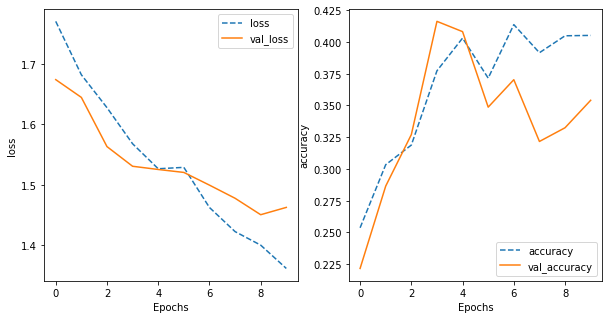

In [25]:
model = train_and_evaluate(lrate=0.0001, l2=0.001, num_hidden = [64, 16])

The 5-flowers dataset is too small for us to take advantage of the additional modeling capability provided by the DNN’s extra layer.

Initially, we did not do better than the linear model, but by adding regularization and lowering the learning rate we were able to get better performance.

There are two ideas—dropout layers and batch normalization—that
are worth trying.

####Dropout

Dropout is one of the oldest regularization techniques in deep learning. At each training iteration, the dropout layer drops random neurons from the network, with a probability `p (typically 25% to 50%)`. In practice, the dropped neurons’ outputs are set to zero. The net result is that these neurons will not participate in the loss computation this time around, and they will not get weight updates. Different neurons will be dropped at each training iteration.

<img src='https://github.com/rahiakela/computer-vision-research-and-practice/blob/main/practical-machine-learning-for-computer-vision/02-ml-models-for-vision/images/5.png?raw=1' width='800'/>

When testing the performance of the network, all the neurons need to be considered (dropout rate=0). Keras does this automatically, so all you have to do is add a tf.keras.layers.Dropout layer. It will automatically have the correct behavior at training and evaluation time: during training, layers are randomly dropped; but during evaluation and prediction, no layers are dropped.

####Batch normalization

Our input pixel values are in the range `[0, 1]`, and this is compatible with the dynamic range of the typical activation functions and optimizers. However, once we add a hidden layer, the resulting output values will no longer lie in the dynamic range of the activation function for subsequent layers. When this happens, the neuron’s output is zero, and because moving a small amount in either direction makes no difference, the gradient is zero. There is no way for the network to escape from the dead zone.

<img src='https://github.com/rahiakela/computer-vision-research-and-practice/blob/main/practical-machine-learning-for-computer-vision/02-ml-models-for-vision/images/6.png?raw=1' width='800'/>

To fix this, batch normalization normalizes neuron outputs across a training batch of data by subtracting the average and dividing by the standard deviation. 

However, doing just that could be swinging the pendulum too far in one direction—with a perfectly
centered and normally wide distribution everywhere, all neurons would have
the same behavior. The trick is to introduce two additional learnable parameters per neuron, called scale and center, and to normalize the input data to the neuron using these values:

$$
normalized = \frac{(input - center)}{scale}
$$

This way, the network decides, through machine learning, how much centering and
rescaling to apply at each neuron.

The problem with batch normalization is that at prediction time you do not have
training batches over which you can compute the statistics of your neurons’ outputs,
but you still need those values. Therefore, during training, neurons’ output statistics are computed across a “sufficient” number of batches using a running exponential average. These stats are then used at inference time.

The good news is that in Keras you can use a tf.keras.layers.BatchNormalization
layer and all this accounting will happen automatically. When using batch normalization, remember that:

- Batch normalization is performed on the output of a layer before the activation
function is applied. So, rather than set `activation='relu'` in the Dense layer’s constructor, we’d omit the activation function there and then add a separate Activation layer.
- If you use `center=True` in batch norm, you do not need biases in your layer. The batch norm offset plays the role of a bias.
- If you use an activation function that is scale-invariant (i.e., does not change shape if you zoom in on it), then you can set `scale=False`. ReLu is scale-invariant. Sigmoid is not.

In [28]:
def train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0.001, dropout_prob=0.4 ,num_hidden=[64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").map(decode_csv)).batch(BATCH_SIZE)
  eval_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").map(decode_csv)).batch(32)  # this doesn't matter

  # NN with multiple hidden layers
  layers = [tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name="input_pixels")]

  for hno, nodes in enumerate(num_hidden):
    layers.extend([
        tf.keras.layers.Dense(nodes, kernel_regularizer=regularizer, activation=tf.keras.activations.relu, name="hidden_dense_{}".format(hno)),
        tf.keras.layers.BatchNormalization(scale=False, center=False, name="batchnorm_dense_{}".format(hno)),
        # move activation to come after batchnorm
        tf.keras.layers.Activation("relu", name="relu_dense_{}".format(hno)),
        tf.keras.layers.Dropout(rate=dropout_prob, name="dropout_dense_{}".format(hno)),                            
    ])
  
  layers.append(tf.keras.layers.Dense(len(CLASS_NAMES), kernel_regularizer=regularizer, activation='softmax', name="flower_prob"))

  model = tf.keras.Sequential(layers, name='flower_classification')

  # compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
  print(model.summary())
  
  # fit the model
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

  # plot the loss and accuracy
  training_plot(['loss', 'accuracy'], history)

  return model

Note that we have moved the activation out of the Dense layer and into a separate layer that comes after batch normalization.

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
batchnorm_dense_0 (BatchNorm (None, 64)                128       
_________________________________________________________________
relu_dense_0 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_dense_0 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
batchnorm_dense_1 (BatchNorm (None, 16)      

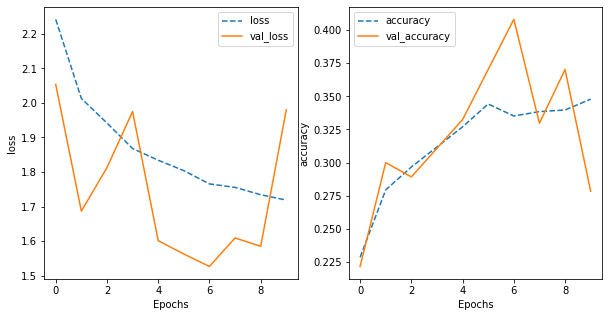

In [29]:
model = train_and_evaluate(dropout_prob=0.4)

The resulting training indicates that these two tricks have improved the ability of the model to generalize and to converge faster. We now get an
accuracy of 0.48, as opposed to 0.40 without batch norm and dropout. 

**Fundamentally, though, the DNN is not much better than a linear model (0.48 vs. 0.46), because a dense network is not the correct way to go deeper.**